In [1]:
# load / unzip

def unzip_tracks(filename):
    import zipfile

    with zipfile.ZipFile(filename,"r") as zf:
            zf = zipfile.ZipFile(filename)
            uncompress_size = sum((file.file_size for file in zf.infolist()))
            extracted_size = 0
            for file in zf.infolist():
                extracted_size += file.file_size
                print((extracted_size / uncompress_size), end='\r',flush=True)
                zf.extract(file)

def get_data(url,filename):
    import urllib.request
    import shutil
    import os
    if(not(os.path.exists(filename))):
        with urllib.request.urlopen(url) as response, open(filename, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)

#get_data('https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip','data.zip')
#unzip_tracks('data.zip')
#unzip_tracks('tracks.zip')
print(os.listdir("."))

In [7]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
#from sklearn.model_selection import StratifiedShuffleSplit

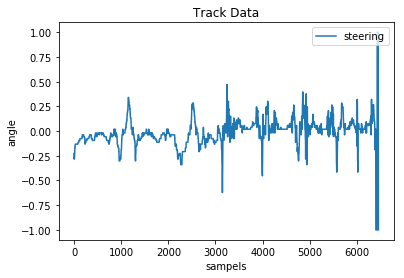

(6458, 8)


In [8]:
# read csv
def get_csv(path):
    # load CSV & drop zeros
    df = pd.read_csv(path+'driving_log.csv')
    df = df.drop(df[df['steering'] == 0.].index)
    df = df.drop(df[df['speed'] < 1.].index)
    df['center'] = path+df['center']
    df['right'] = path+df['right']
    df['left'] = path+df['left']
    return df

tracks = [#get_csv(path = './data/'),\
          get_csv(path = './andy_track1_forward/'),\
          get_csv(path = './andy_track1_backward/'),\
          get_csv(path = './andy_track1_offroad/'),\
         ]
df = pd.concat(tracks).reset_index()

def plot_steering(df):
    ### plot 
    plt.plot(df['steering'])
    plt.title('Track Data')
    plt.ylabel('angle')
    plt.xlabel('sampels')
    plt.legend(['steering'], loc='upper right')
    #plt.yscale('log')
    plt.show()
    
plot_steering(df)
print(df.shape)

In [9]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=1/21, random_state=42)

In [10]:
# argumentation and batching parameters:
image_shape = (160,320,3) #cv2.imread( df['center'][df['center'].index[0]]).shape

steering_argumentation_offset = .22
steering_argumentation_scale = 1.3

batch_size_single = 40

In [11]:
##### generate argumentated batch

from sklearn.utils import shuffle

def get_batch(df,batch_size_single): 
    n_split = int(len(df)//batch_size_single)-1
    batch_idx = (df[:batch_size_single*n_split].index.values)   
    batch_idx = shuffle(batch_idx)
    batch_idx = batch_idx.reshape(n_split,batch_size_single,)
    while 1:
        batch_y            = np.empty(list([batch_size_single*6]))
        batch_x            = np.empty(list([batch_size_single*6]) + list(image_shape))
        for idxes in batch_idx:
            inc = 0
            for idx in idxes:
                batch_y[0+inc]      =  (steering_argumentation_scale*df['steering'][idx] + steering_argumentation_offset) 
                batch_y[1+inc]      = -(steering_argumentation_scale*df['steering'][idx] + steering_argumentation_offset) 
                batch_y[2+inc]      =  (steering_argumentation_scale*df['steering'][idx] - steering_argumentation_offset) 
                batch_y[3+inc]      = -(steering_argumentation_scale*df['steering'][idx] - steering_argumentation_offset) 
                batch_y[4+inc]      =  (df['steering'][idx]) 
                batch_y[5+inc]      = -(df['steering'][idx]) 
                batch_x[0+inc]      = cv2.imread(df['left'][idx].replace(" ", "")) 
                batch_x[1+inc]      = cv2.imread(df['left'][idx].replace(" ", ""))[:,-1::-1]
                batch_x[2+inc]      = cv2.imread(df['right'][idx].replace(" ", ""))  
                batch_x[3+inc]      = cv2.imread(df['right'][idx].replace(" ", ""))[:,-1::-1]
                batch_x[4+inc]      = cv2.imread(df['center'][idx].replace(" ", ""))  
                batch_x[5+inc]      = cv2.imread(df['center'][idx].replace(" ", ""))[:,-1::-1]
                inc += 6
            assert(not(np.isnan((np.sum(batch_x)))))
            assert(not(np.isnan((np.sum(batch_y)))))
            #yield (batch_x,batch_y)             
            yield shuffle(batch_x,batch_y) 

train_generator = get_batch(df_train, batch_size_single=batch_size_single)
validation_generator = get_batch(df_val, batch_size_single=batch_size_single)

(240, 160, 320, 3)


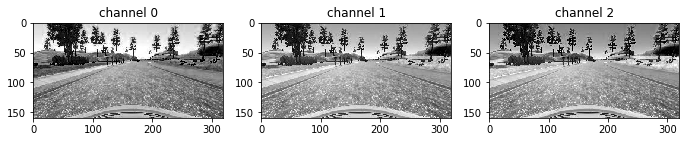

steering: 0.05660377, idx: 0


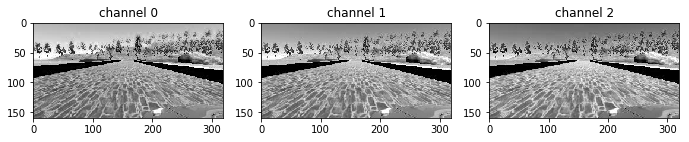

steering: 0.244528296, idx: 40


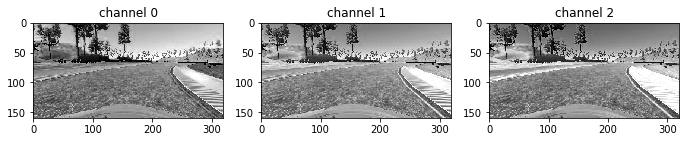

steering: 0.245283, idx: 80


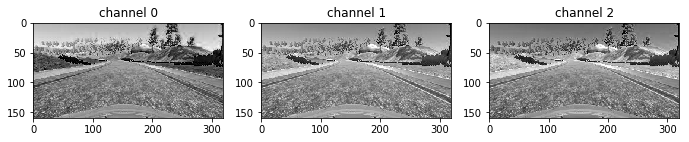

steering: -0.09433963, idx: 120


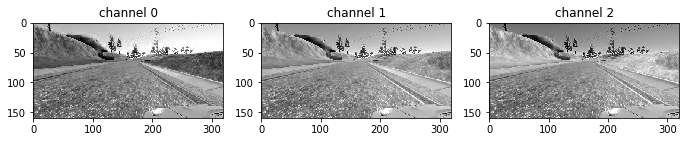

steering: 0.195471704, idx: 160


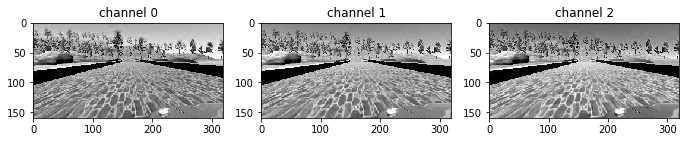

steering: 0.170943395, idx: 200
CPU times: user 4.64 s, sys: 4.38 s, total: 9.02 s
Wall time: 4.76 s


In [12]:
def visualise_dataset(image,label,steps):
    plt_num = 1
    print(image.shape)
    step_size = int(image.shape[0]/steps)
    for image_idx in range(0,image.shape[0],step_size):
        channels = image.shape[3]
        plt.figure(plt_num, figsize=(32,32))
        for channel in range(channels):
            plt.subplot(4,8, channel+1) # sets the number of feature maps to show on each row and column
            plt.title('channel ' + str(channel)) # displays the feature map number
            plt.imshow(image[image_idx,:,:, channel], interpolation="nearest", cmap="gray") # cmap="gist_earth_r"
        plt.show()
        print('steering: {1}, idx: {0}'.format(image_idx,label[image_idx],))

batch_x,batch_y = next(train_generator)
%time visualise_dataset(batch_x,batch_y,steps=6)

In [13]:
import matplotlib

def plot_history_object(history_object):
    ### print the keys contained in the history object
    print(history_object.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.yscale('log')
    plt.show()


In [ ]:
from keras.models import Sequential,load_model
from keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D, SeparableConv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

import tensorflow as tf

# Hyperparameter Compile
loss= 'mse' # 'hinge'
optimizer= 'Nadam' #'Nadam' #'rmsprop'
# Hyperparameter Fit
rounds = 5
n_batches = len(df_train)//batch_size_single

nb_epoch= n_batches * rounds
batch_size = batch_size_single * 6
patience=5000

print('nb_epoch   \t: {:>5}'.format(nb_epoch))
print('batch_size \t: {:>5}'.format(batch_size))
print('patience   \t: {:>5}'.format(patience))

def model():
    model = Sequential()
    model.add(Cropping2D(cropping=((65,23), (0,0)), input_shape=image_shape)) #23
    #model.add(Lambda(lambda x: (x[:,:,:,0:1]+x[:,:,:,1:2]+x[:,:,:,2:3])/3)) ## drive on gray
    model.add(Lambda(lambda x: x/127.5 - 1.))
    output_shape = ((model.layers[-1].output_shape))
    model.add(Reshape((output_shape[1]*2,int(output_shape[2]/2),output_shape[3],)))
    a = 4
    model.add(Convolution2D(2**(a+0), 9, 9, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(2**(a+1), 7, 7, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(2**(a+2), 5, 5, subsample=(1, 1), border_mode="same", activation = 'elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(2**(a+3), 3, 3, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(2**(a+4), 3, 3, subsample=(2, 2), border_mode="same", activation = 'elu'))
    model.add(Convolution2D(2**(a+5), 3, 3, subsample=(1, 1), border_mode="same", activation = 'elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())  
    model.add(Flatten())
    #model.add(Dropout(.66))
    model.add(Dense(4**4, activation = 'sigmoid'))
    model.add(Dense(3**3, activation = 'relu'))
    model.add(Dense(2**2, activation = 'linear'))
    model.add(Dense(1**1, activation = 'linear'))
    return model

try:
    model = load_model('model.h5')
    #model.load_weights("model.h5")
    print("load_weights done")
except:
    print("load_weights failed")
    model = model()
    print("model initialised")
model.summary()

%time model.compile(loss=loss, optimizer=optimizer)

losses = []
def plot_loss(epoch, logs):
    try:
        if(len(logs['loss'])>5):
            losses.append(logs['loss'])
            plt.plot(losses)
            plt.show()
    except:
        pass

def callbacks():
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience,verbose=0,)
    model_checkpoit = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    plot_loss_callback = LambdaCallback(on_epoch_end=plot_loss)
    return [early_stopping,model_checkpoit,plot_loss_callback]

while(1):
    history_object = model.fit_generator(generator         = train_generator, \
                        samples_per_epoch = batch_size*6, \
                        validation_data   = validation_generator, \
                        nb_val_samples    = 1, \
                        nb_epoch          = nb_epoch,\
                        callbacks         = callbacks() \
                                        )

plot_history_object(history_object)

import winsound
winsound.Beep(130,10000)

nb_epoch   	:   765
batch_size 	:   240
patience   	:  5000
load_weights done
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 72, 320, 3)    0           cropping2d_input_2[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 72, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 144, 160, 3)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 72, 80, 16)    3904        reshape_1[0][0]                  
_____________

In [ ]:
import argparse
import base64
from datetime import datetime
import os
import shutil

import numpy as np
import socketio
import eventlet
import eventlet.wsgi
from PIL import Image
from flask import Flask
from io import BytesIO

from keras.models import load_model
import h5py
from keras import __version__ as keras_version

model = load_model('model.h5')
print("load_model done")

sio = socketio.Server()
app = Flask(__name__)
prev_image_array = None


class SimplePIController:
    def __init__(self, Kp, Ki):
        self.Kp = Kp
        self.Ki = Ki
        self.set_point = 0.
        self.error = 0.
        self.integral = 0.

    def set_desired(self, desired):
        self.set_point = desired

    def update(self, measurement):
        # proportional error
        self.error = self.set_point - measurement
        # integral error
        self.integral += self.error
        return self.Kp * self.error + self.Ki * self.integral

controller = SimplePIController(0.1, 0.002)
set_speed = 15
controller.set_desired(set_speed)

@sio.on('telemetry')
def telemetry(sid, data):
    if data:
        # The current steering angle of the car
        steering_angle = data["steering_angle"]
        # The current throttle of the car
        throttle = data["throttle"]
        # The current speed of the car
        speed = data["speed"]
        # The current image from the center camera of the car
        imgString = data["image"]
        image = Image.open(BytesIO(base64.b64decode(imgString)))
        image_array = np.asarray(image)
        steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))
        throttle = controller.update(float(speed))
        print(steering_angle, throttle)
        send_control(steering_angle, throttle)
    else:
        # NOTE: DON'T EDIT THIS.
        sio.emit('manual', data={}, skip_sid=True)


@sio.on('connect')
def connect(sid, environ):
    print("connect ", sid)
    send_control(0, 0)

def send_control(steering_angle, throttle):
    sio.emit(
        "steer",
        data={
            'steering_angle': steering_angle.__str__(),
            'throttle': throttle.__str__()
        },
        skip_sid=True)

# wrap Flask application with engineio's middleware
app = socketio.Middleware(sio, app)

# deploy as an eventlet WSGI server
eventlet.wsgi.server(eventlet.listen(('', 4567)), app)


In [ ]:
'''
def get_StratifiedShuffleSplit(batches_idx,batch_size):
    n_bins  = 5
    batch_size = 5*7*7
    y_classes = df['steering'].copy()*n_bins//1
    batches_idx = df.index
    data_size = len(batches_idx)
    n_split = int(data_size//batch_size)-1
    print(n_split)
    batch_range = df.index
    sss = StratifiedShuffleSplit(n_splits = n_split,test_size = 15)
    batch_idx, val_idx = next(sss.split((batch_range),(y_classes.values)))
    
    batch_idx = batch_idx[:batch_size*n_split].reshape((n_split,batch_size, ))
    batch_idx = batch_idx[:batch_size*n_split].reshape((n_split,batch_size, ))
    
    return batch_idx, val_idx

    batch_idx, val_idx = (get_batch_idx(batches_idx,batch_size = 256))
    batch_idx.shape
    
    #from keras.layers.recurrent import LSTM, GRU, SimpleRNN
#from keras.layers.wrappers import TimeDistributed
#from keras.regularizers import l2, activity_l2


'''